In [1]:
# imports
%matplotlib inline
from collections import Counter
import re
import time
import nltk
from sklearn import (datasets, decomposition, ensemble, manifold, random_projection)
from nltk.corpus import stopwords
import os
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from tqdm import tqdm_notebook
import scipy.stats as sstats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
import string
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import datasets
stop_words = set(stopwords.words('english'))
sns.set_style('whitegrid')

In [2]:
airline = pd.read_csv('Tweets.csv')
airlines = airline.airline.unique()
for e in airlines:
    print(airline[airline['airline'] == e]['text'])
airline = airline[['text', 'airline_sentiment']]
airlines = ['VirginAmerica','united','SouthwestAir','JetBlue','USAirways','AmericanAir']
airline.head()

0                    @VirginAmerica What @dhepburn said.
1      @VirginAmerica plus you've added commercials t...
2      @VirginAmerica I didn't today... Must mean I n...
3      @VirginAmerica it's really aggressive to blast...
4      @VirginAmerica and it's a really big bad thing...
                             ...                        
499    @VirginAmerica morning. If I have a question r...
500    @VirginAmerica still waiting to see  @Starryey...
501    @VirginAmerica was wondering if you guys recie...
502    @VirginAmerica Flying LAX to SFO and after loo...
503    “@VirginAmerica: Book out of town with fares f...
Name: text, Length: 504, dtype: object
504                                        @united thanks
505     @united Thanks for taking care of that MR!! Ha...
506     @united still no refund or word via DM. Please...
507     @united Delayed due to lack of crew and now de...
508     @united thanks -- we filled it out. How's our ...
                              ...           

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [3]:
negs = airline[airline['airline_sentiment'] == 'negative']['text']
poss = airline[airline['airline_sentiment'] == 'positive']['text']
neus = airline[airline['airline_sentiment'] == 'neutral']['text']

# RBF KERNELS

### Basic SVM

In [8]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [56]:
clf.score(X_test,y_test)

0.6379781420765027

It's already better thank KNN. But it just predicts everything as 'negative'

In [59]:
np.unique(clf.predict(X_test))

array(['negative'], dtype=object)

#### Scaled gamma

In [23]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(gamma='scale')
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)

31.402284383773804


In [24]:
clf.score(X_test,y_test)

0.7838114754098361

### What if we balance the dataset?

#### for scaled gamma

In [25]:
#balancing classes
negs = airline[airline['airline_sentiment'] == 'negative']
poss = airline[airline['airline_sentiment'] == 'positive']
neus = airline[airline['airline_sentiment'] == 'neutral']
balanceddf = pd.concat([negs,neus,neus,neus,poss,poss,poss,poss])
balanceddf = balanceddf.reset_index()
balanceddf = balanceddf.drop(balanceddf.columns[0],axis=1)
balanceddf.head()

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(balanceddf['text'])
X_train, X_test, y_train, y_test = train_test_split(X, balanceddf['airline_sentiment'], test_size=0.1)
prev = time.time()
clf = SVC(gamma='scale')
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)


309.6987795829773


In [26]:
clf.score(X_test,y_test)

0.9273182957393483

In [27]:
np.unique(clf.predict(X_test))

array(['negative', 'neutral', 'positive'], dtype=object)

#### now we first get test set and then balance

In [33]:
msk = np.random.rand(len(airline)) < 0.8
train = airline[msk]
test = airline[~msk]
negs = train[train['airline_sentiment'] == 'negative']
poss = train[train['airline_sentiment'] == 'positive']
neus = train[train['airline_sentiment'] == 'neutral']
balanceddf = pd.concat([negs,neus,neus,neus,poss,poss,poss,poss])
balanceddf = balanceddf.reset_index()
balanceddf = balanceddf.drop(balanceddf.columns[0],axis=1)
balanceddf.head()

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(balanceddf['text'])
Y = vectorizer.transform(test['text'])
X_train = X
X_test = Y
y_train = balanceddf['airline_sentiment']
y_test = test['airline_sentiment']

prev = time.time()
clf = SVC(gamma='scale')
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

189.26635551452637


0.78755586112066

#### few different options along with different kernels

In [35]:
prev = time.time()
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)a
clf.score(X_test,y_test)

168.70934510231018


0.45926435201100035

In [36]:
prev = time.time()
clf = SVC(gamma='scale',C=1000)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

204.95463347434998


0.7854932966655208

In [37]:
prev = time.time()
clf = SVC(gamma='auto',C=1000)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

79.82643532752991


0.7765555173599175

In [38]:
prev = time.time()
clf = SVC(gamma='scale', kernel='linear')
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

119.84278392791748


0.7645238913716054

In [39]:
prev = time.time()
clf = SVC(gamma='scale',kernel='sigmoid')
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

73.65490674972534


0.7071158473702304

In [40]:
prev = time.time()
clf = SVC(gamma='auto', kernel='linear', C=0.1)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

72.30181360244751


0.768992781024407

### Testing for different C

#### auto

In [12]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = np.arange(1,110)
print(len(cs))
for i in range(109):
    clf = SVC(gamma='auto',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))
    
    

109


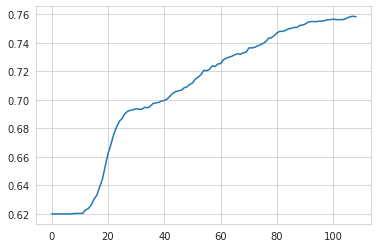

In [14]:
plt.plot(accs)
plt.show()

### more tests for higher values

In [4]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = np.arange(100,400,10)
for i in range(len(cs)):
    clf = SVC(gamma='auto',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))
    

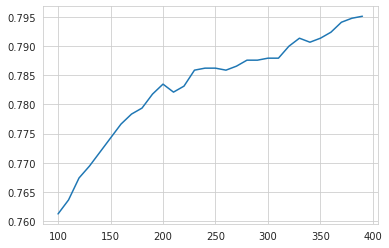

In [7]:
plt.plot(cs,accs)
plt.show()

In [8]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = np.arange(500,1000,40)
for i in range(len(cs)):
    clf = SVC(gamma='auto',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

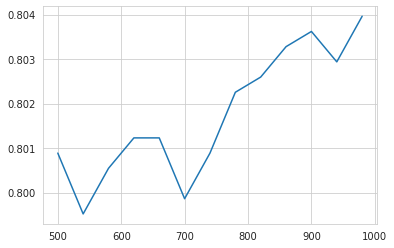

In [9]:
plt.plot(cs,accs)
plt.show()

In [12]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = np.arange(1000,5001,1000)
for i in range(len(cs)):
    clf = SVC(gamma='auto',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

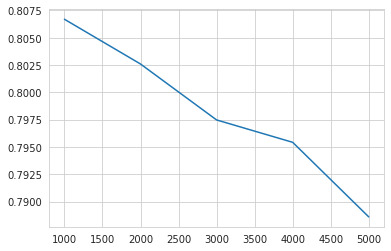

In [13]:
plt.plot(cs,accs)
plt.show()

#### scale

In [42]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = np.arange(1000,5001,1000)
for i in range(len(cs)):
    clf = SVC(gamma='scale',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

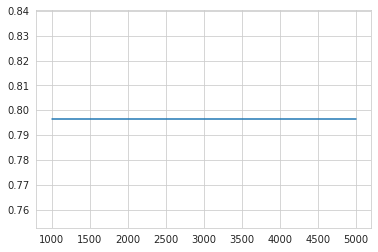

In [43]:
plt.plot(cs,accs)
plt.show()

In [44]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = np.arange(500,1000,40)
for i in range(len(cs)):
    clf = SVC(gamma='scale',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

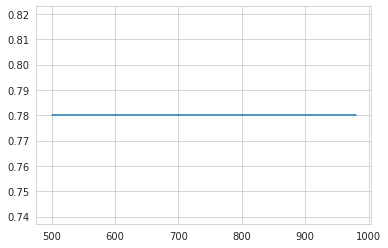

In [45]:
plt.plot(cs,accs)
plt.show()

In [46]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = np.arange(1,110)
print(len(cs))
for i in range(109):
    clf = SVC(gamma='scale',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

109


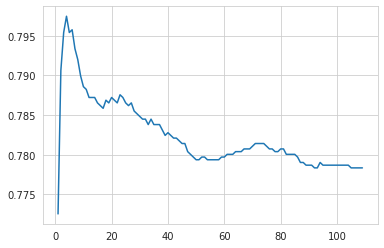

In [47]:
plt.plot(cs,accs)
plt.show()

### Checking different gammas

In [4]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(gamma=0.001,C=1000)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)

32.49304676055908


In [5]:
clf.score(X_test,y_test)

0.766051912568306

In [6]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(gamma=0.01,C=100)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)

33.34952116012573


In [7]:
clf.score(X_test,y_test)

0.7807377049180327

### Preprocessing testing

### stemming without punctuation and numbers

In [4]:
copyair = airline.copy()
newtext = []
for tweet in copyair['text']:
    e = re.sub(r'\d+', '', tweet)
    e = e.translate(str.maketrans('', '', string.punctuation))
    stemmer= PorterStemmer()
    e=word_tokenize(e)
    newtext.append(' '.join(e))

copyair['text'] = newtext

In [49]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(copyair['text'])
X_train, X_test, y_train, y_test = train_test_split(X, copyair['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(gamma='scale')
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

29.40772294998169


0.7991803278688525

In [50]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(copyair['text'])
X_train, X_test, y_train, y_test = train_test_split(X, copyair['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(gamma='auto',C=1000)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

21.78237771987915


0.8084016393442623

# LINEAR KERNEL

### Basic SVM with linear kernel

In [9]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(gamma='auto', kernel='linear')
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

29.01036763191223


0.7752732240437158

### Testing for different C (values based on previous experiments)

In [17]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = [0.01,0.1,1,10,100,500,1000]
print(len(cs))
for i in range(len(cs)):
    clf = SVC(gamma='auto',kernel='linear',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

7


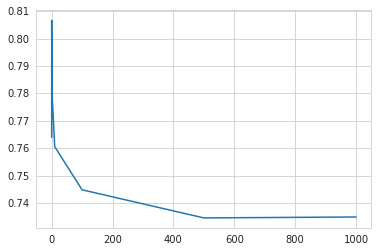

In [18]:
plt.plot(cs,accs)
plt.show()

In [6]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = [0.01,0.1,1,10,100,500,1000]
print(len(cs))
for i in range(len(cs)):
    clf = SVC(gamma='scale',kernel='linear',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

7


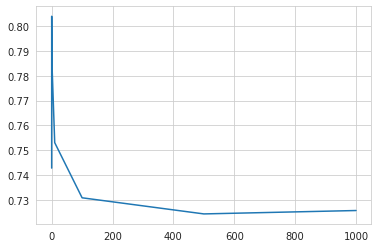

In [7]:
plt.plot(cs,accs)
plt.show()

In [8]:
print(accs)

[0.742827868852459, 0.8039617486338798, 0.7848360655737705, 0.7530737704918032, 0.7308743169398907, 0.7243852459016393, 0.7257513661202186]


### Different parameters

In [51]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(gamma='scale',kernel='linear')
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

29.39283561706543


0.7848360655737705

In [52]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(gamma='auto', kernel='linear')
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

29.33910298347473


0.7783469945355191

### Testing preprocessings

#### tokenization, removing punctuation and numbers

In [53]:
copyair = airline.copy()
newtext = []
for tweet in copyair['text']:
    e = re.sub(r'\d+', '', tweet)
    e = e.translate(str.maketrans('', '', string.punctuation))
    stemmer= PorterStemmer()
    e=word_tokenize(e)
    newtext.append(' '.join(e))

copyair['text'] = newtext

In [55]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(copyair['text'])
X_train, X_test, y_train, y_test = train_test_split(X, copyair['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(kernel='linear',C=0.1)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

23.837204456329346


0.8077185792349727

#### removing punctuation

In [56]:
copyair = airline.copy()
newtext = []
for tweet in copyair['text']:
    e = tweet
    e = e.translate(str.maketrans('', '', string.punctuation))

    newtext.append(e)

copyair['text'] = newtext

In [57]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(copyair['text'])
X_train, X_test, y_train, y_test = train_test_split(X, copyair['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(kernel='linear',C=0.1)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

22.113012313842773


0.805327868852459

#### removing punctuation and tokenization

In [7]:
copyair = airline.copy()
newtext = []
for tweet in copyair['text']:
    e = tweet
    e = e.translate(str.maketrans('', '', string.punctuation))
    stemmer= PorterStemmer()
    e=word_tokenize(e)
    newtext.append(' '.join(e))

copyair['text'] = newtext

In [59]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(copyair['text'])
X_train, X_test, y_train, y_test = train_test_split(X, copyair['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(kernel='linear',C=0.1)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

22.48422336578369


0.8159153005464481

#### like last one but a bit different parameters

In [10]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(copyair['text'])
X_train, X_test, y_train, y_test = train_test_split(X, copyair['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(kernel='linear',C=0.01)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

25.167784452438354


0.7667349726775956

# POLY KERNEL

### Basic SVM with polynomial kernel

In [10]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(gamma='auto', kernel='poly')
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

24.0908944606781


0.6267076502732241

### Testing for different C (values based on previous experiments)

In [9]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = [0.01,0.1,1,10,100,500,1000]
print(len(cs))
for i in range(len(cs)):
    clf = SVC(gamma='auto',kernel='poly',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

7


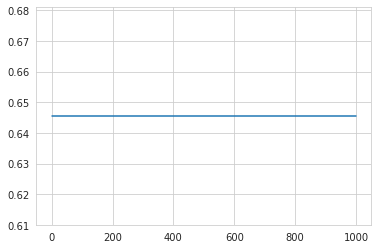

In [10]:
plt.plot(cs,accs)
plt.show()

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = [0.01,0.1,1,10,100,500,1000]
print(len(cs))
for i in range(len(cs)):
    clf = SVC(gamma='scale',kernel='poly',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

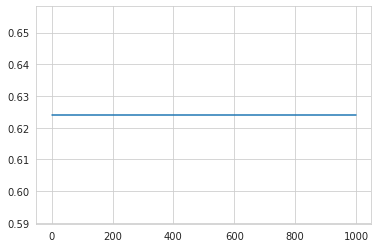

In [16]:
plt.plot(cs,accs)
plt.show()

In [ ]:
# :/

In [19]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = [0.00001,0.0001]
print(len(cs))
for i in range(len(cs)):
    clf = SVC(gamma='auto',kernel='poly',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

2


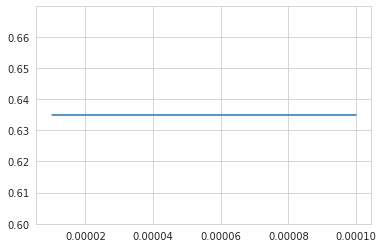

In [20]:
plt.plot(cs,accs)
plt.show()

In [21]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = [10000,50000]
print(len(cs))
for i in range(len(cs)):
    clf = SVC(gamma='auto',kernel='poly',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

2


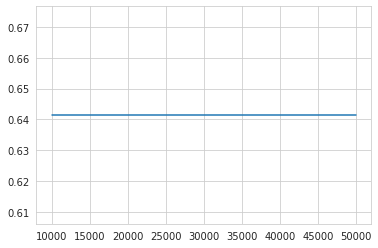

In [22]:
plt.plot(cs,accs)
plt.show()

### Testing coef0 values

In [52]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = [0.01,0.1,1,10,100,500,1000]
print(len(cs))
for i in range(len(cs)):
    clf = SVC(gamma='scale',kernel='poly',coef0=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

7


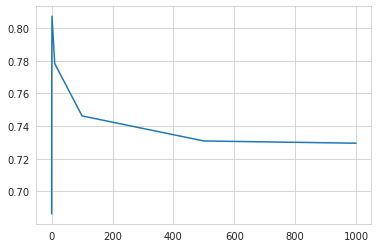

In [53]:
plt.plot(cs,accs)
plt.show()

### Testing polynomial degrees

In [4]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = [1,2,3,5,10]
print(len(cs))
for i in range(len(cs)):
    clf = SVC(gamma='scale',kernel='poly',degree=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

5


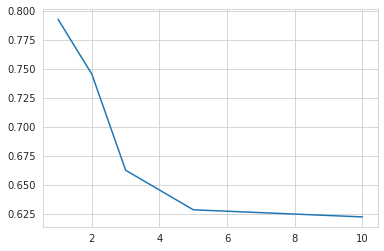

In [5]:
plt.plot(cs,accs)
plt.show()

### Different preprocessings

#### tokenization, removing numbers and punctuation

In [32]:
copyair = airline.copy()
newtext = []
for tweet in copyair['text']:
    e = re.sub(r'\d+', '', tweet)
    e = e.translate(str.maketrans('', '', string.punctuation))
    stemmer= PorterStemmer()
    e=word_tokenize(e)
    newtext.append(' '.join(e))

copyair['text'] = newtext

In [34]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(copyair['text'])
X_train, X_test, y_train, y_test = train_test_split(X, copyair['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(kernel='poly',gamma='auto',coef0=0.1)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

24.947672128677368


0.6294398907103825

#### removing punctuation

In [37]:
copyair = airline.copy()
newtext = []
for tweet in copyair['text']:
    e = tweet
    e = e.translate(str.maketrans('', '', string.punctuation))

    newtext.append(e)

copyair['text'] = newtext

In [38]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(copyair['text'])
X_train, X_test, y_train, y_test = train_test_split(X, copyair['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(kernel='poly',gamma='auto',coef0=0.1)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

26.575438976287842


0.6314890710382514

#### removing punctuation and tokenization

In [40]:
copyair = airline.copy()
newtext = []
for tweet in copyair['text']:
    e = tweet
    e = e.translate(str.maketrans('', '', string.punctuation))
    stemmer= PorterStemmer()
    e=word_tokenize(e)
    newtext.append(' '.join(e))

copyair['text'] = newtext

In [41]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(copyair['text'])
X_train, X_test, y_train, y_test = train_test_split(X, copyair['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(kernel='poly',gamma='auto',coef0=0.1)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

26.10347604751587


0.6191939890710383

# SIGMOID KERNEL

### Basic SVM with sigmoid kernel

In [11]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(gamma='auto', kernel='sigmoid')
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

26.59796118736267


0.6168032786885246

### Testing for different C (values based on previous experiments)

In [13]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = [0.01,0.1,1,10,100,500,1000]
print(len(cs))
for i in range(len(cs)):
    clf = SVC(gamma='auto',kernel='sigmoid',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

7


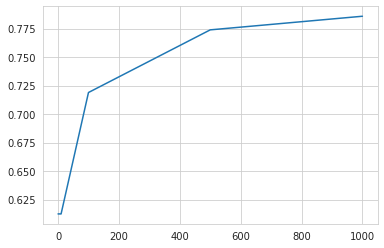

In [14]:
plt.plot(cs,accs)
plt.show()

In [57]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = [1000,2000,3000,4000]
print(len(cs))
for i in range(len(cs)):
    clf = SVC(gamma='auto',kernel='sigmoid',C=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

4


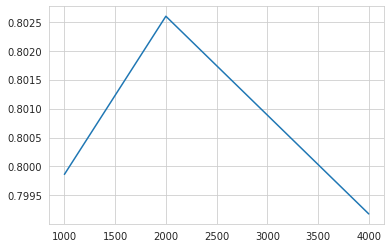

In [58]:
plt.plot(cs,accs)
plt.show()

### Testing different coef0 values

In [4]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(airline['text'])
X_train, X_test, y_train, y_test = train_test_split(X, airline['airline_sentiment'], test_size=0.2)
accs = []
cs = [0.01,0.1,1,10,100,500,1000]
print(len(cs))
for i in range(len(cs)):
    clf = SVC(gamma='scale',kernel='sigmoid',coef0=cs[i])
    clf.fit(X_train,y_train)
    accs.append(clf.score(X_test,y_test))

7


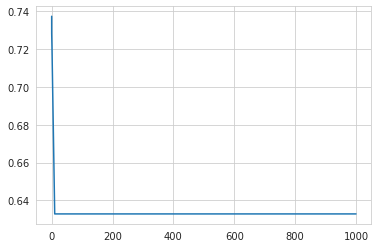

In [5]:
plt.plot(cs,accs)
plt.show()

### Some preprocessings

#### tokenizer, removing numbers and punctuation

In [11]:
copyair = airline.copy()
newtext = []
for tweet in copyair['text']:
    e = re.sub(r'\d+', '', tweet)
    e = e.translate(str.maketrans('', '', string.punctuation))
    stemmer= PorterStemmer()
    e=word_tokenize(e)
    newtext.append(' '.join(e))

copyair['text'] = newtext

In [13]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(copyair['text'])
X_train, X_test, y_train, y_test = train_test_split(X, copyair['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(kernel='sigmoid',gamma='auto',C=2000)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

24.805400609970093


0.8162568306010929

#### removing punctuation

In [25]:
copyair = airline.copy()
newtext = []
for tweet in copyair['text']:
    e = e.translate(str.maketrans('', '', string.punctuation))
    newtext.append(e)

copyair['text'] = newtext

In [27]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(copyair['text'])
X_train, X_test, y_train, y_test = train_test_split(X, copyair['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(kernel='sigmoid',gamma='auto',C=2000)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

14.129487991333008


0.6181693989071039

#### tokenization and removing punctuation

In [30]:
copyair = airline.copy()
newtext = []
for tweet in copyair['text']:
    e = tweet
    e = e.translate(str.maketrans('', '', string.punctuation))
    stemmer= PorterStemmer()
    e=word_tokenize(e)
    newtext.append(' '.join(e))

copyair['text'] = newtext

In [31]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(copyair['text'])
X_train, X_test, y_train, y_test = train_test_split(X, copyair['airline_sentiment'], test_size=0.2)
prev = time.time()
clf = SVC(kernel='sigmoid',gamma='auto',C=2000)
clf.fit(X_train, y_train)
curr = time.time()
print(curr-prev)
clf.score(X_test,y_test)

22.53132653236389


0.8056693989071039